In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

plt.style.use('ggplot')
COLORS = list(mcolors.TABLEAU_COLORS.keys())

ERA_DEADBALL = (1901, 1919)
ERA_LIVEBALL = (1920, 1941)
ERA_INTEGRATION = (1942, 1960)
ERA_EXPANSION = (1961, 1976)
ERA_FREEAGENCY = (1977, 1993)
ERA_STEROID = (1994, 2005)
ERA_MODERN = (2006, 2022)

ERAS = [
    { 'label' : 'Deadball', 'color' : 'blue', 'dates' : ERA_DEADBALL },
    { 'label' : 'Liveball', 'color' : 'red', 'dates' : ERA_LIVEBALL },
    { 'label' : 'Integration', 'color' : 'green', 'dates' : ERA_INTEGRATION },
    { 'label' : 'Expansion', 'color' : 'purple', 'dates' : ERA_EXPANSION },
    { 'label' : 'Free Agency', 'color' : 'orange', 'dates' : ERA_FREEAGENCY },
    { 'label' : 'Steroid', 'color' : 'cyan', 'dates' : ERA_STEROID },
    { 'label' : 'Modern', 'color' : 'olive', 'dates' : ERA_MODERN },
]
PERCENTILES = [
    {
        'col' : 'nanmin',
        'label' : 'Min',
        'color' : 'tab:brown',
    },
    {
        'col' : 'percentile_25',
        'label' : '25th percentile',
        'color' : 'tab:cyan',
    },
    {
        'col' : 'percentile_50',
        'label' : 'Median',
        'color' : 'tab:blue',
    },
    {
        'col' : 'percentile_75',
        'label' : '75th percentile',
        'color' : 'tab:green',
    },
    {
        'col' : 'percentile_95',
        'label' : '95th percentile',
        'color' : 'tab:red',
    },
    {
        'col' : 'nanmax',
        'label' : 'Max',
        'color' : 'tab:olive',
    },
]

STATS = {
    'avg' : 'Batting Average',
    'obp' : 'OBP',
    'slg' : 'SLG',
    'ops' : 'OPS',
    'babip' : 'BABIP',
    '_1b' : 'Singles',
    '_2b' : 'Doubles',
    '_3b' : 'Triples',
    '_4b' : 'Home Runs',
    'rbi' : 'RBIs',
    'sb' : 'Stolen Bases',
    'bb' : 'Walks',
    'so' : 'Strikeouts',
    'ab' : 'At Bats',
    'pa' : 'Plate Appearances',
}

STAT_2_MAJORTICK = {
    'avg' : .05,
    'babip' : .05,
    'obp' : .1,
    'slg' : .1,
    'ops' : .5,
    '_1b' : 50,
    '_2b' : 5,
    '_3b' : 5,
    '_4b' : 10,
    'rbi' : 20,
    'sb' : 20,
    'bb' : 50,
    'so' : 50,
    'ab' : 50,
    'pa' : 50,
}
QUALIFYING_BATTER_PA_CUTOFF = 400

def np_percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def print_all_tables(db: sqlalchemy.engine):
    inspector = sqlalchemy.inspect(db)
    for table in inspector.get_table_names():
        print(f"Table: {table}")

def print_all_columns(db: sqlalchemy.engine, table_name: str):
    inspector = sqlalchemy.inspect(db)
    for column in inspector.get_columns(table_name):
        print(f"Column: {column['name']}")

Dataset: https://www.kaggle.com/datasets/open-source-sports/baseball-databank

Factsheet: https://cran.r-project.org/web/packages/Lahman/Lahman.pdf

In [3]:
db = sqlalchemy.create_engine('sqlite:////Users/mwornow/boxball/sqlite/boxball.db')

df_ppl = pd.read_sql('select * from baseballdatabank_people', db)
df_batting = pd.read_sql('select * from baseballdatabank_batting', db)
df_hof = pd.read_sql('select * from baseballdatabank_hall_of_fame', db)

print_all_tables(db)

Table: baseballdatabank_allstar_full
Table: baseballdatabank_appearances
Table: baseballdatabank_awards_managers
Table: baseballdatabank_awards_players
Table: baseballdatabank_awards_share_managers
Table: baseballdatabank_awards_share_players
Table: baseballdatabank_batting
Table: baseballdatabank_batting_post
Table: baseballdatabank_college_playing
Table: baseballdatabank_fielding
Table: baseballdatabank_fielding_of
Table: baseballdatabank_fielding_of_split
Table: baseballdatabank_fielding_post
Table: baseballdatabank_hall_of_fame
Table: baseballdatabank_home_games
Table: baseballdatabank_managers
Table: baseballdatabank_managers_half
Table: baseballdatabank_parks
Table: baseballdatabank_people
Table: baseballdatabank_pitching
Table: baseballdatabank_pitching_post
Table: baseballdatabank_salaries
Table: baseballdatabank_schools
Table: baseballdatabank_series_post
Table: baseballdatabank_teams
Table: baseballdatabank_teams_franchises
Table: baseballdatabank_teams_half
Table: retrosheet

In [26]:
df_stats = pd.merge(df_batting, df_ppl)
for col in set(df_batting.columns) - { 'player_id', 'year_id', 'stint', 'team_id', 'lg_id' } :
    df_stats[col] = df_stats[col].replace(r'^\s*$', 0, regex=True).astype(int)
df_stats['_4b'] = df_stats['hr']
df_stats['_1b'] = df_stats['h'] - df_stats['_2b'] - df_stats['_3b'] - df_stats['_4b'] 
df_stats['avg'] = df_stats['h'] / df_stats['ab']
df_stats['obp'] = (df_stats['h'] + df_stats['bb'] + df_stats['hbp']) / (df_stats['ab'] + df_stats['bb'] + df_stats['hbp'] + df_stats['sf'])
df_stats['slg'] = (1 * df_stats['_1b'] + 2 * df_stats['_2b'] + 3 * df_stats['_3b'] + 4 * df_stats['_4b']) / df_stats['ab']
df_stats['ops'] = df_stats['obp'] + df_stats['slg']
df_stats['babip'] = (df_stats['h'] - df_stats['_4b']) / (df_stats['ab'] - df_stats['_4b'] - df_stats['so'] + df_stats['sf']) 
df_stats['pa'] = df_stats['ab'] + df_stats['bb'] + df_stats['hbp'] + df_stats['sh'] + df_stats['sf']
df_stats

player_id  year_id  stint team_id lg_id   g   ab   r   h  _2b  ...  \
0       abercda01     1871      1     TRO    NA   1    4   0   0    0  ...   
1        addybo01     1871      1     RC1    NA  25  118  30  32    6  ...   
2        addybo01     1873      1     PH2    NA  10   51  12  16    1  ...   
3        addybo01     1873      2     BS1    NA  31  152  37  54    6  ...   
4        addybo01     1874      1     HR1    NA  50  213  25  51    9  ...   
...           ...      ...    ...     ...   ...  ..  ...  ..  ..  ...  ...   
110490  wilsoja03     2021      1     OAK    AL   6    7   1   1    0  ...   
110491  wilsoja03     2021      2     HOU    AL   6   13   2   2    1  ...   
110492   wongco01     2021      1     BOS    AL   6   13   3   4    1  ...   
110493   yanghy01     2021      1     TEX    AL  12    0   0   0    0  ...   
110494  zerpaan01     2021      1     KCA    AL   1    0   0   0    0  ...   

        retro_id   bbref_id  _4b  _1b       avg       obp       slg       ops  \
0       aberd101  abercda01    0    0  0.000000  0.000000  0.000000  0.000000   
1       addyb101   addybo01    0   26  0.271186  0.295082  0.322034  0.617116   
2       addyb101   addybo01    0   15  0.313725  0.339623  0.333333  0.672956   
3       addyb101   addybo01    1   44  0.355263  0.363636  0.453947  0.817584   
4       addyb101   addybo01    0   40  0.239437  0.242991  0.300469  0.543460   
...          ...        ...  ...  ...       ...       ...       ...       ...   
110490  wilsj005  wilsoja04    0    1  0.142857  0.142857  0.142857  0.285714   
110491  wilsj005  wilsoja04    0    0  0.153846  0.214286  0.384615  0.598901   
110492  wongc001   wongco01    0    2  0.307692  0.357143  0.538462  0.895604   
110493  yangh001   yanghy01    0    0       NaN       NaN       NaN       NaN   
110494  zerpa001  zerpaan01    0    0       NaN       NaN       NaN       NaN   

           babip   pa  
0       0.000000    4  
1       0.271186  122  
2       0.313725   53  
3       0.353333  154  
4       0.240566  214  
...          ...  ...  
110490  0.166667    7  
110491  0.181818   14  
110492  0.666667   14  
110493       NaN    0  
110494       NaN    0  

[110495 rows x 53 columns]

In [27]:
df_qualified = df_stats[(df_stats['pa'] > QUALIFYING_BATTER_PA_CUTOFF) & (df_stats['year_id'] >= ERA_DEADBALL[0]) ].copy()
df_stats_by_year = df_qualified.groupby('year_id').agg({
    x: ([np.nanmin] + [ np_percentile(y) for y in range(0, 101)] + [np.nanmax]) for x in STATS
}).reset_index()
df_stats_by_year

year_id       avg                                                      \
               nanmin percentile_0 percentile_1 percentile_2 percentile_3   
0      1901  0.184270     0.184270     0.195942     0.212652     0.215966   
1      1902  0.185185     0.185185     0.192963     0.213154     0.218038   
2      1903  0.184932     0.184932     0.211910     0.223224     0.224669   
3      1904  0.188867     0.188867     0.199777     0.207209     0.209873   
4      1905  0.192308     0.192308     0.200309     0.207787     0.208831   
..      ...       ...          ...          ...          ...          ...   
115    2016  0.185542     0.185542     0.205834     0.216609     0.220717   
116    2017  0.192941     0.192941     0.201261     0.204573     0.208189   
117    2018  0.168085     0.168085     0.201171     0.207470     0.208627   
118    2019  0.204611     0.204611     0.207730     0.215945     0.217940   
119    2021  0.162791     0.162791     0.189365     0.200387     0.209279   

                                                         ...            pa  \
    percentile_4 percentile_5 percentile_6 percentile_7  ... percentile_92   
0       0.229171     0.233913     0.238976     0.244123  ...        625.88   
1       0.221564     0.224183     0.228529     0.231257  ...        611.56   
2       0.225273     0.227173     0.230572     0.231020  ...        607.00   
3       0.212504     0.213101     0.217260     0.220823  ...        661.00   
4       0.211171     0.213368     0.215648     0.216982  ...        672.40   
..           ...          ...          ...          ...  ...           ...   
115     0.224353     0.227232     0.230525     0.233340  ...        692.12   
116     0.211614     0.216136     0.220298     0.224636  ...        678.60   
117     0.220231     0.222368     0.224631     0.226107  ...        679.84   
118     0.222753     0.225814     0.226358     0.227489  ...        681.84   
119     0.209785     0.211820     0.214535     0.216265  ...        674.00   

                                                                           \
    percentile_93 percentile_94 percentile_95 percentile_96 percentile_97   
0          629.42        631.80        635.30        637.20        641.18   
1          612.00        615.78        622.75        626.56        629.68   
2          610.72        614.76        615.95        635.20        642.79   
3          661.00        661.12        662.50        667.48        673.18   
4          674.72        675.76        680.00        681.00        682.76   
..            ...           ...           ...           ...           ...   
115        694.49        696.00        698.35        700.28        704.42   
116        680.95        684.80        689.75        691.80        694.00   
117        683.00        688.40        695.90        702.60        705.00   
118        689.72        692.94        697.75        701.88        702.97   
119        677.03        678.74        682.15        687.48        690.87   

                                                       
    percentile_98 percentile_99 percentile_100 nanmax  
0          642.36        646.68          673.0    673  
1          636.14        637.21          640.0    640  
2          646.92        651.95          674.0    674  
3          676.20        681.66          714.0    714  
4          689.44        690.96          699.0    699  
..            ...           ...            ...    ...  
115        715.28        719.77          744.0    744  
116        706.80        717.70          725.0    725  
117        706.92        707.98          745.0    745  
118        705.96        712.99          747.0    747  
119        693.32        704.38          724.0    724  

[120 rows x 1546 columns]

# Plotting

In [38]:
def _plot_add_eras(ax: plt.Axes, df_: pd.DataFrame):
    for era in ERAS:
        ax.axvspan(era['dates'][0], era['dates'][1] + .75, color=era['color'], alpha=0.2)
        ax.annotate(era['label'], xy=(era['dates'][0] + (era['dates'][1] - era['dates'][0]) / 2, df_.max().max()), ha='center', weight='bold')

def _plot_set_year_xticks(ax: plt.Axes):
    _plot_set_xticks(ax, 20, "Year")

def _plot_set_xticks(ax: plt.Axes, major_step: float, label: str):
    ax.xaxis.set_major_locator(MultipleLocator(major_step))
    ax.xaxis.set_minor_locator(MultipleLocator(major_step / 5))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%d" if int(major_step) == major_step else "%.2f"))
    ax.set_axisbelow(False)
    for x in ax.get_xticklabels(which='major'):
        x.set_weight('bold')
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.tick_params(axis="x", which='both', direction="inout", color='grey', width=1, length=10)
    ax.set_xlabel(f"{label}")
    
def plot_line(stat: str, stat_label: str, df_stats_by_year: pd.DataFrame) -> plt.Axes:
    fig, ax = plt.subplots(figsize=(15,10))
    for percentile in PERCENTILES:
        col = percentile['col']
        label = percentile['label']
        color = percentile['color']
        ax.plot(df_stats_by_year['year_id'], df_stats_by_year[stat][col], color=color, label=label)
    # ax.plot(df_stats[df_stats['bbref_id'] == 'troutmi01']['year_id'], df_stats[df_stats['bbref_id'] == 'troutmi01']['avg'], label='Trout', color='k')
    ax.set_title(f"{stat_label} Percentiles Over Time")
    ax.set_ylabel(f"{stat_label}")
    ax.margins(.01)
    plt.legend()
    _plot_set_year_xticks(ax)
    plt.savefig(f"output/line__{stat}.png", facecolor='white')
    return ax

def plot_hist(stat: str, stat_label: str, df_stats_by_year: pd.DataFrame, x_tick_major_step: float) -> plt.Axes:
    fig, ax = plt.subplots(figsize=(15,10))
    for idx, percentile in enumerate(PERCENTILES):
        col = percentile['col']
        label = percentile['label']
        color = percentile['color']
        if col == 'nanmin' and stat in ['_3b', '_4b', 'sb', ]:
            # Hide min for these columns b/c ~100 years have min as "0", which distorts rest of plot
            continue
        sns.histplot(df_stats_by_year[stat][col], bins=20, stat='count', ax=ax, alpha=0.2, kde=True, color=color, label=label)
    ax.set_title(f"Distribution of {stat_label} Percentiles Across All Seasons")
    ax.set_ylabel("Density")
    ax.margins(.01)
    plt.legend()
    _plot_set_xticks(ax, x_tick_major_step, stat_label)
    plt.savefig(f"output/hist__{stat}.png", facecolor='white')
    return ax

def plot_dotplot_gradient(stat: str, stat_label: str, df_stats_by_year: pd.DataFrame) -> plt.Axes:
    # Same as above plot, but don't discretize
    fig, ax = plt.subplots(figsize=(20,10))
    df_ = df_stats_by_year[stat]
    colors = cm.get_cmap('viridis', df_.shape[1])(np.linspace(0, 1, df_.shape[1]))
    for percentile in df_.columns:
        for idx, year in enumerate(df_stats_by_year['year_id']):
            ax.scatter([year]*df_.shape[1], df_.iloc[idx], color=colors, s=50)
    ax.autoscale()
    ax.margins(.01)
    ax.set_title(f"{stat_label} Percentiles")
    ax.set_ylabel(f"{stat_label}")
    ax.set_xlabel(f"Year")
    cbar = fig.colorbar(lc, ticks=[0, .5, 1])
    cbar.ax.set_yticklabels(['0th Percentile', 'Median', '100th Percentile'])
    plt.savefig(f"output/gradient_dotplot__{stat}.png", facecolor='white')

def plot_gradient(stat: str, stat_label: str, df_stats_by_year: pd.DataFrame) -> plt.Axes:
    # Same as above plot, but don't discretize
    fig, ax = plt.subplots(figsize=(20,10))
    df_ = df_stats_by_year[stat]
    for idx, year in enumerate(df_stats_by_year['year_id']):
        points = np.array([[year] * df_.shape[1], df_.iloc[idx]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:] + 0.001], axis=1)
        lc = LineCollection(segments, cmap='coolwarm', linewidths=11)
        lc.set_array(np.linspace(0,1,points.shape[0]))
        ax.add_collection(lc)
    ax.autoscale()
    cbar = fig.colorbar(lc, ticks=[0, .5, 1])
    cbar.ax.set_yticklabels(['0th Percentile', 'Median', '100th Percentile'])
    ax.margins(.01)
    ax.set_title(f"{stat_label} Percentiles")
    ax.set_ylabel(f"{stat_label}")
    _plot_set_year_xticks(ax)
    _plot_add_eras(ax, df_)
    plt.savefig(f"output/gradient__{stat}.png", facecolor='white')

# Analysis

/var/folders/l3/6s68f1xn5d59vwpf4qtswbtc0000gn/T/ipykernel_40789/207068074.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20,10))


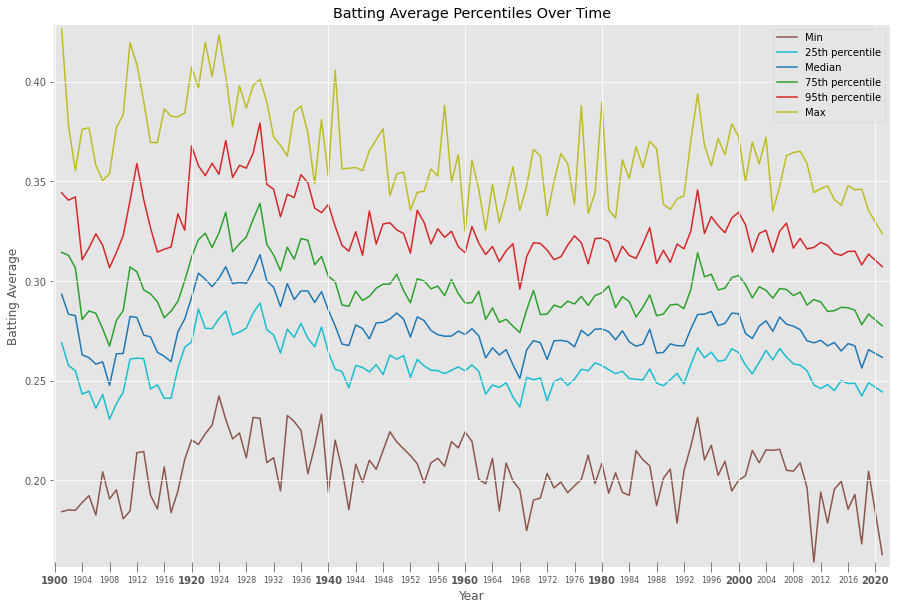

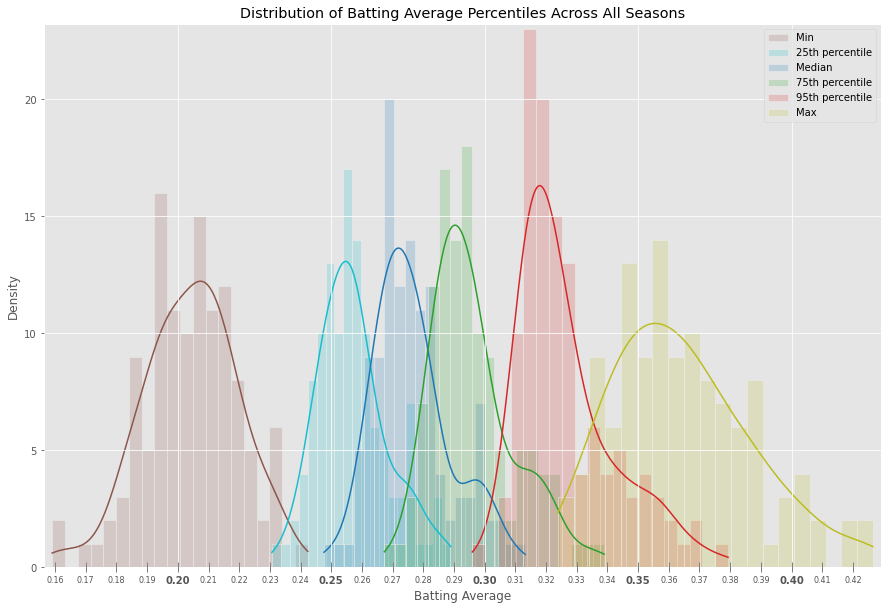

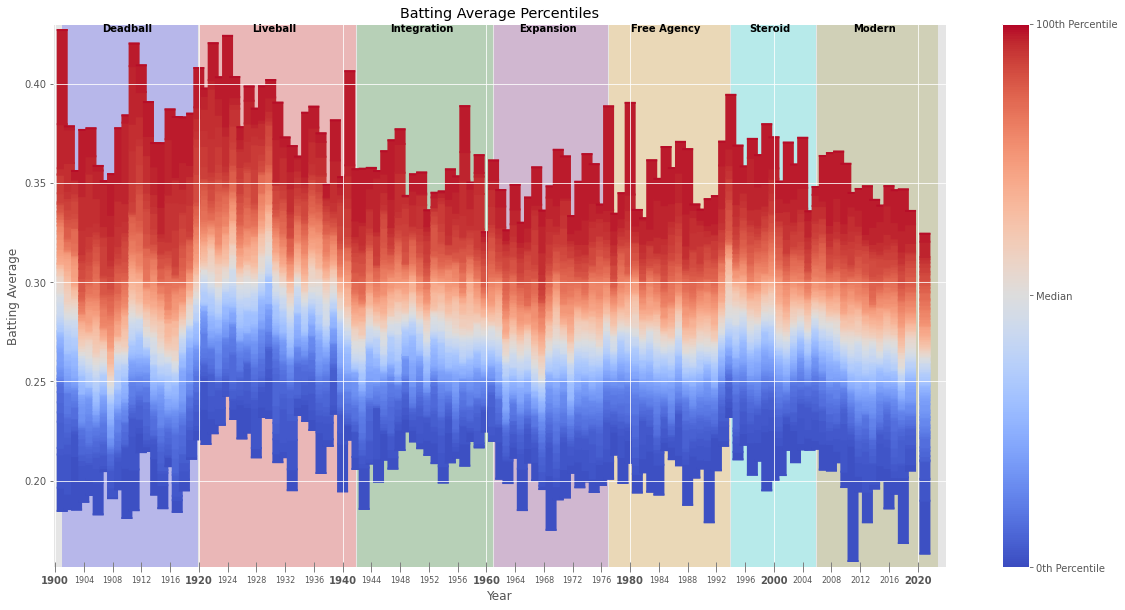

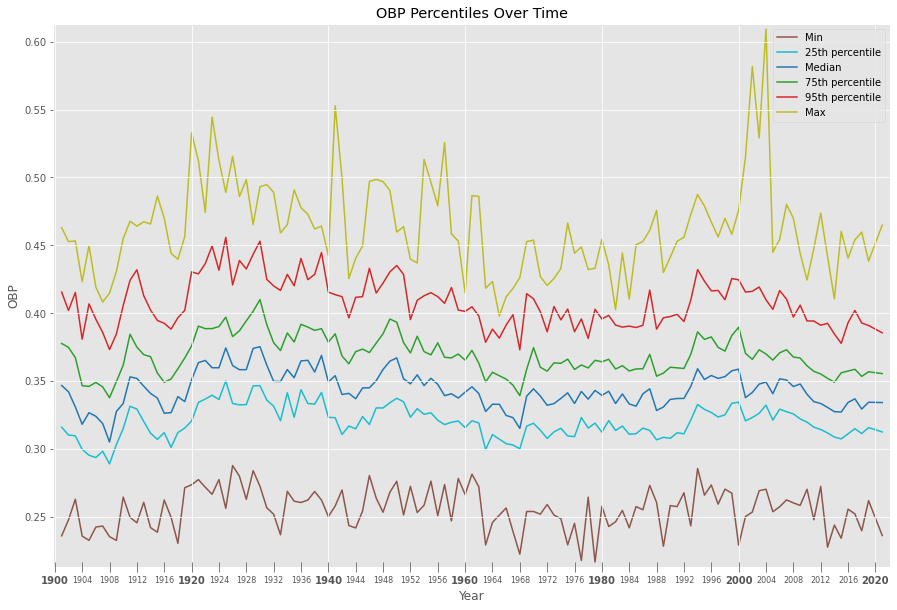

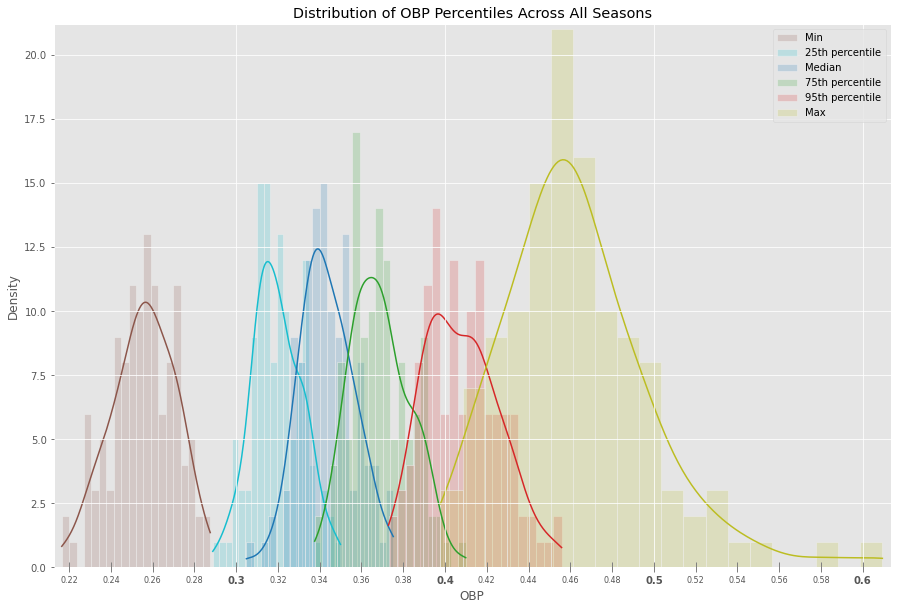

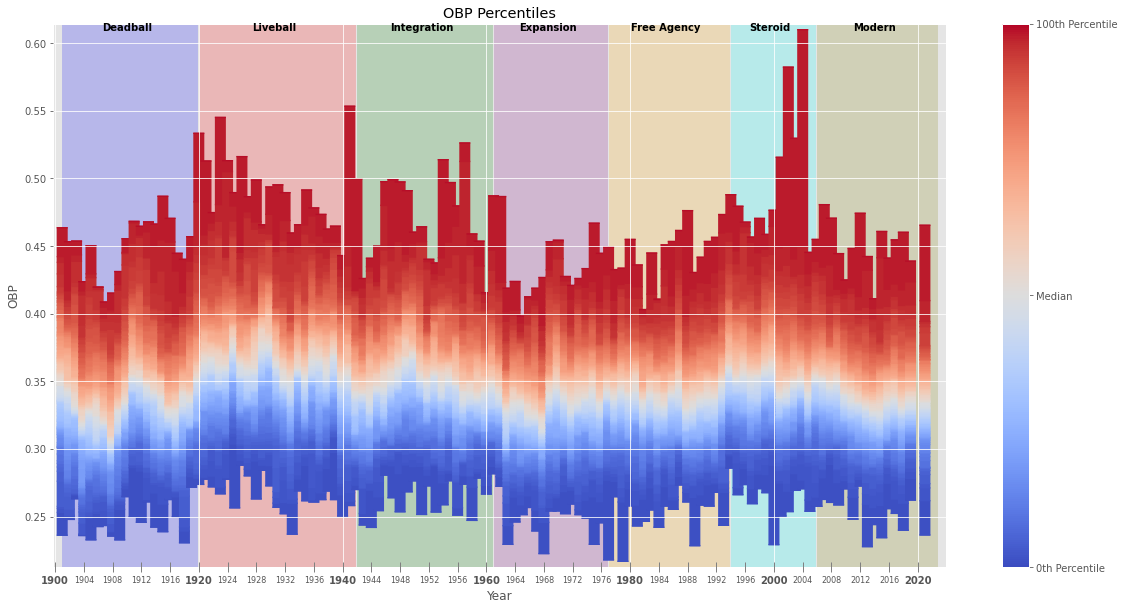

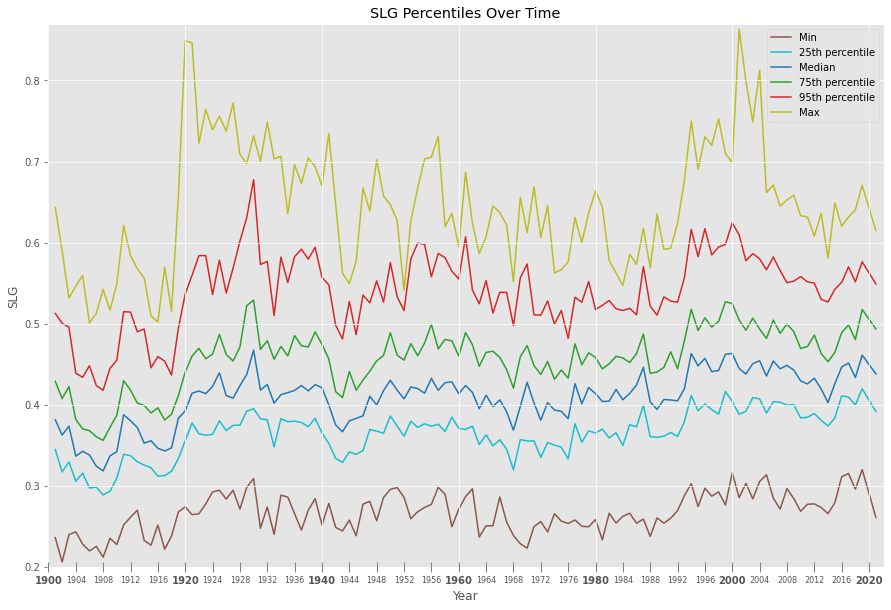

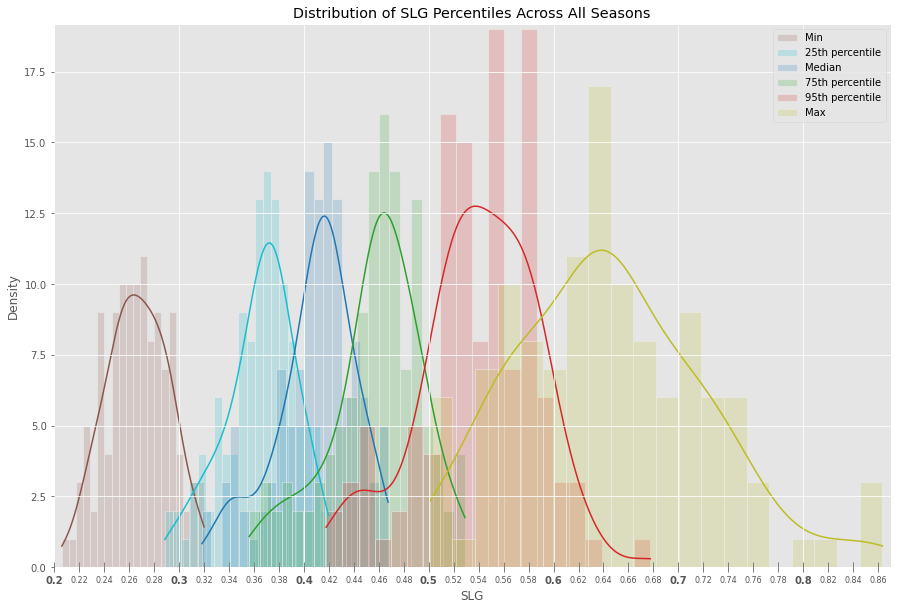

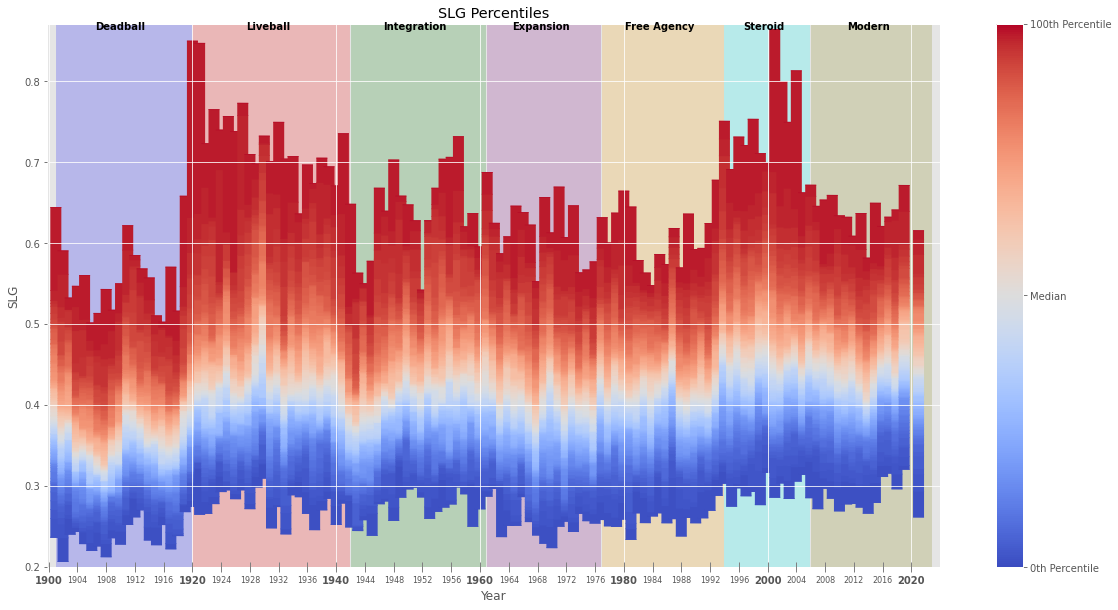

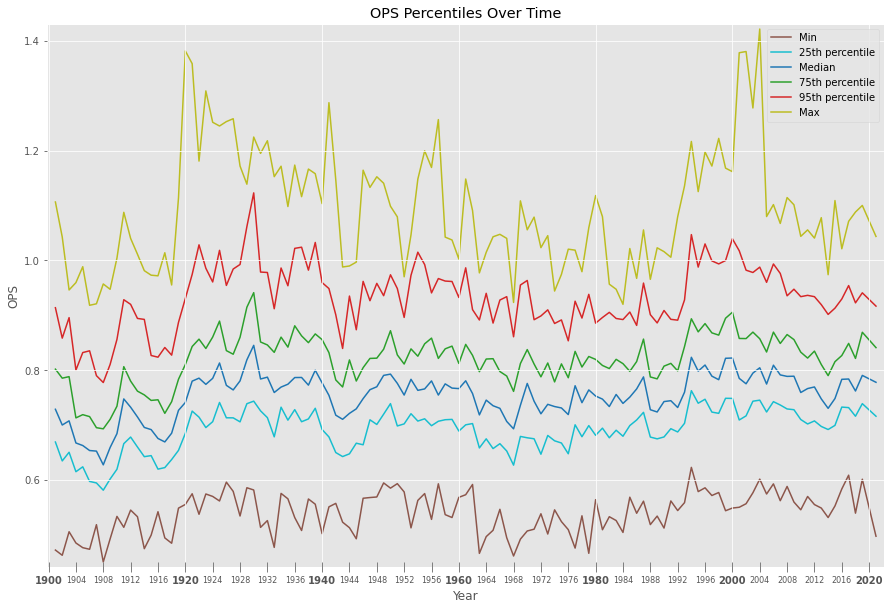

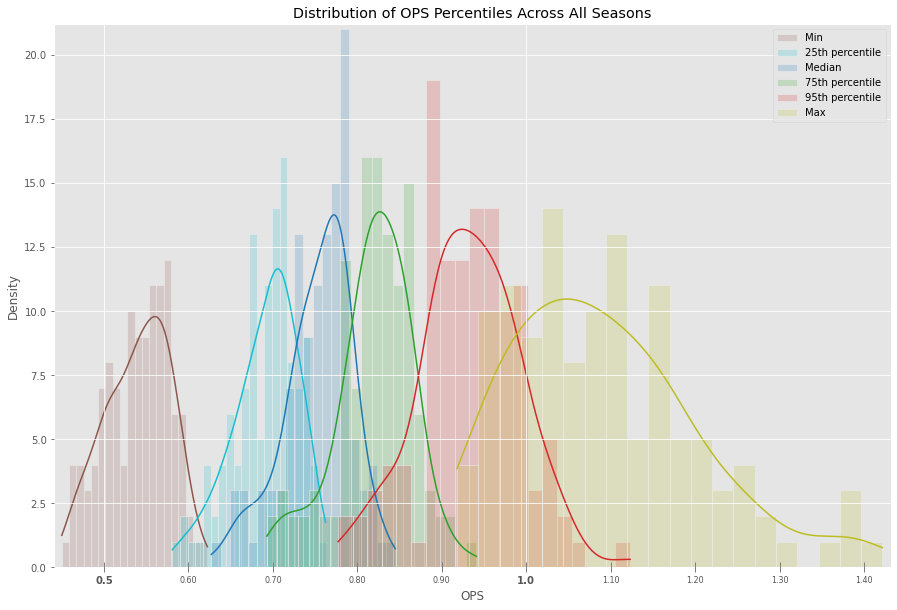

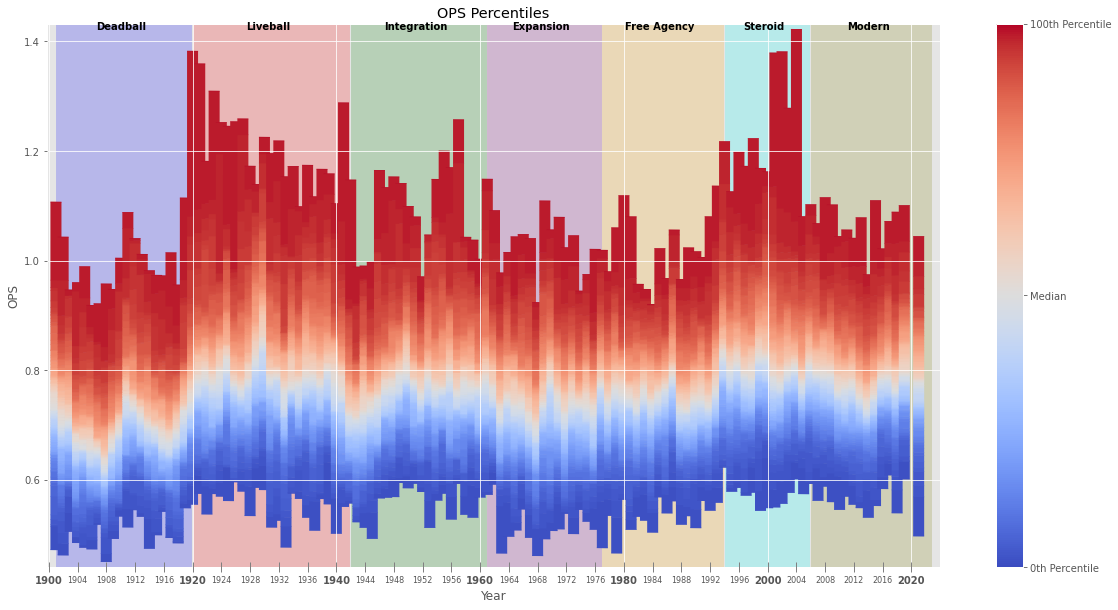

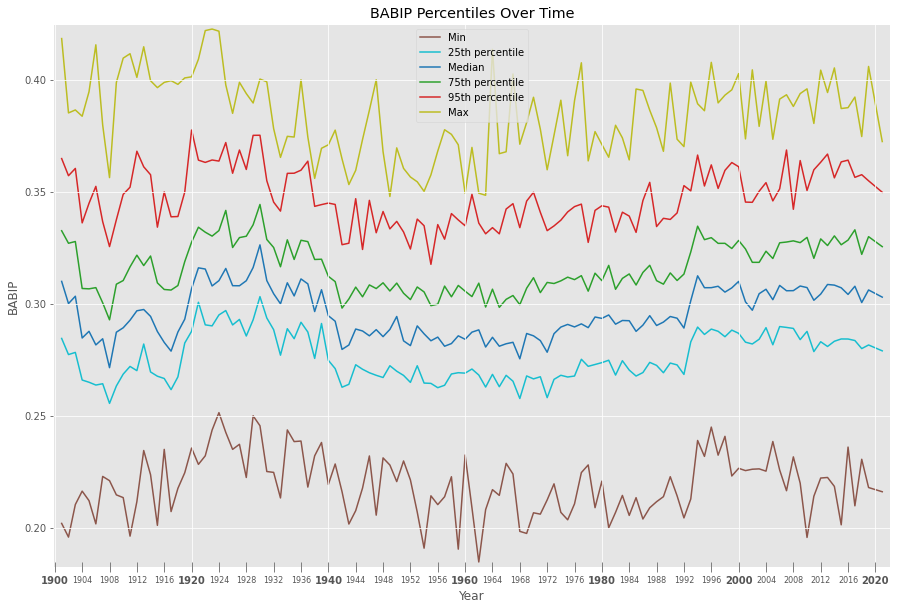

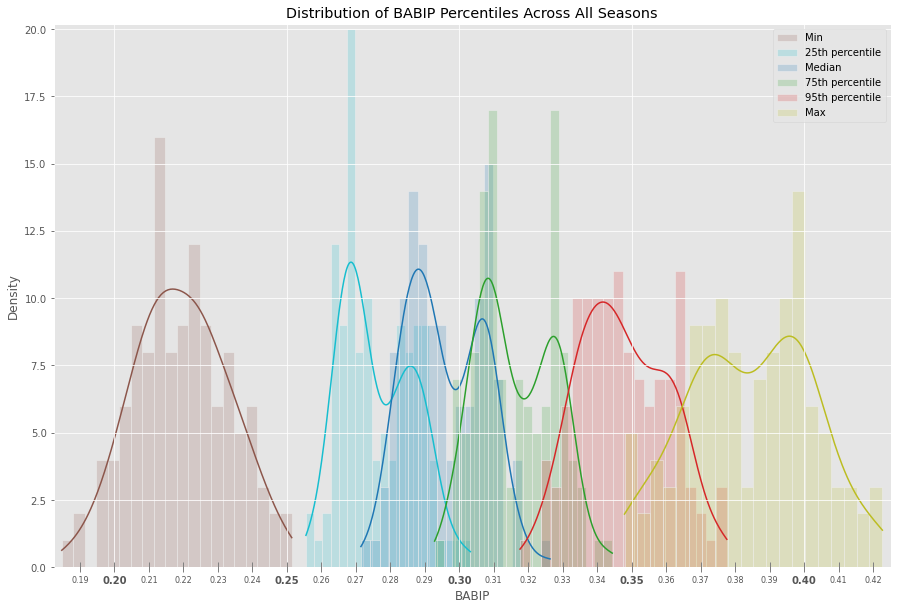

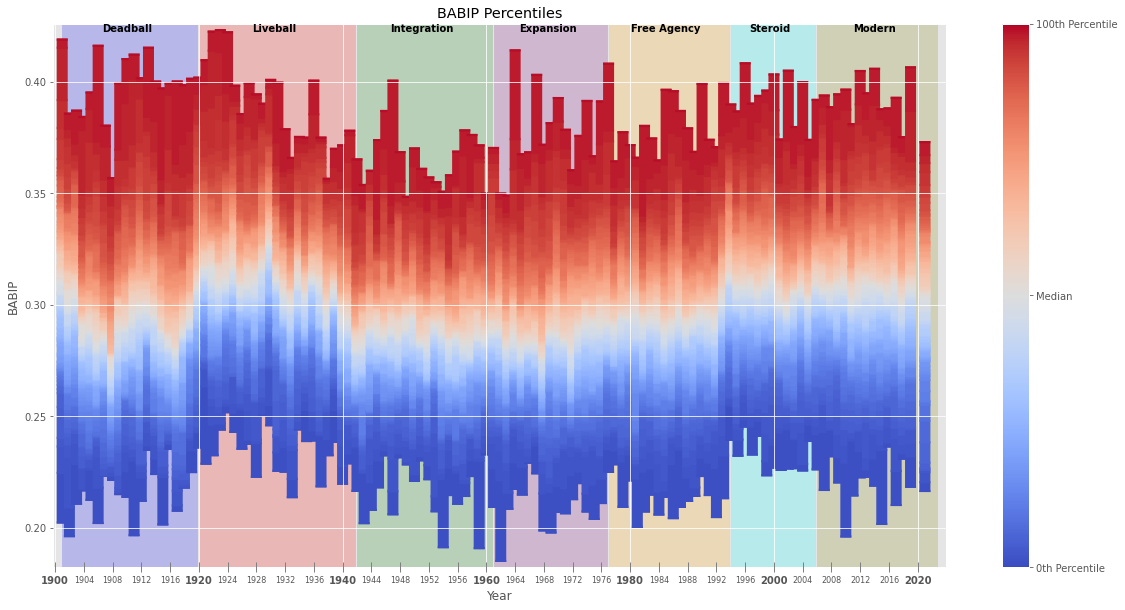

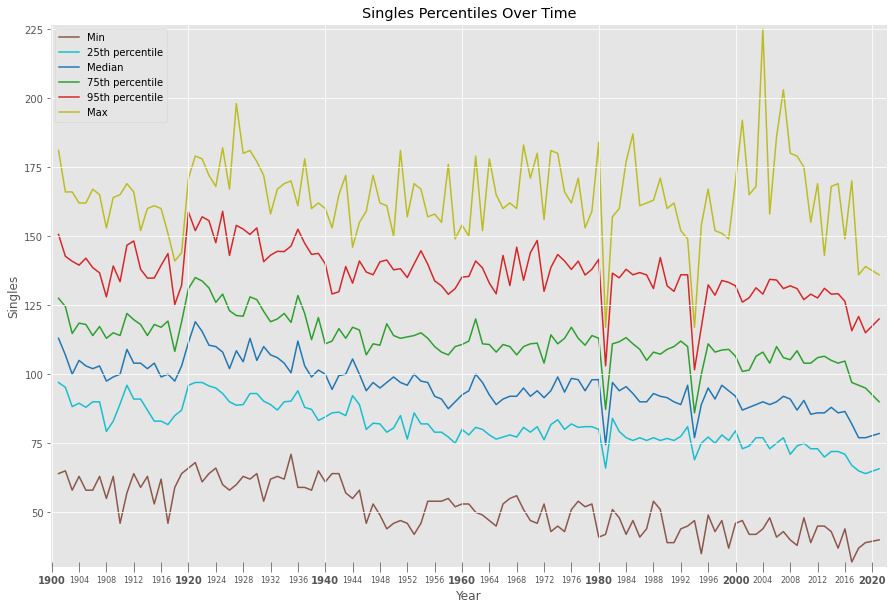

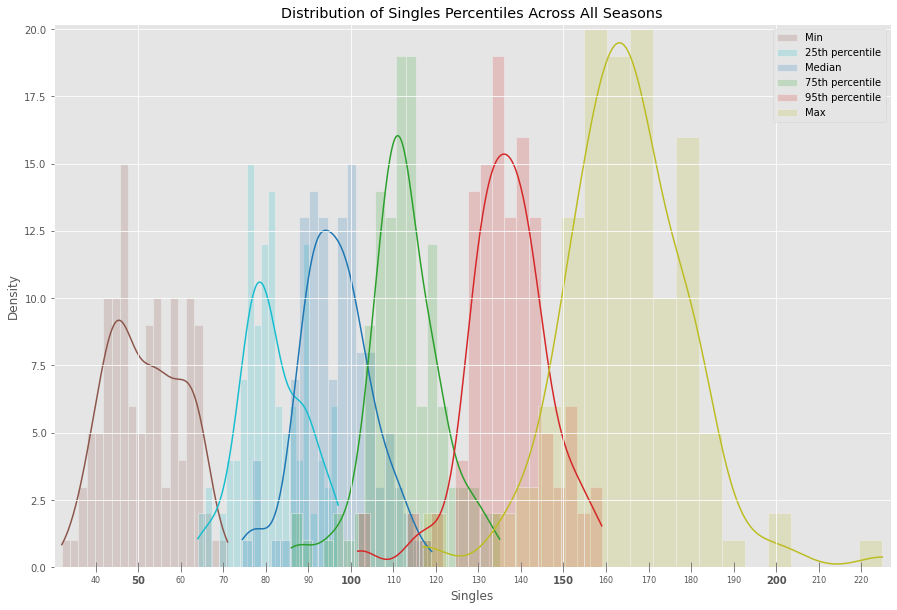

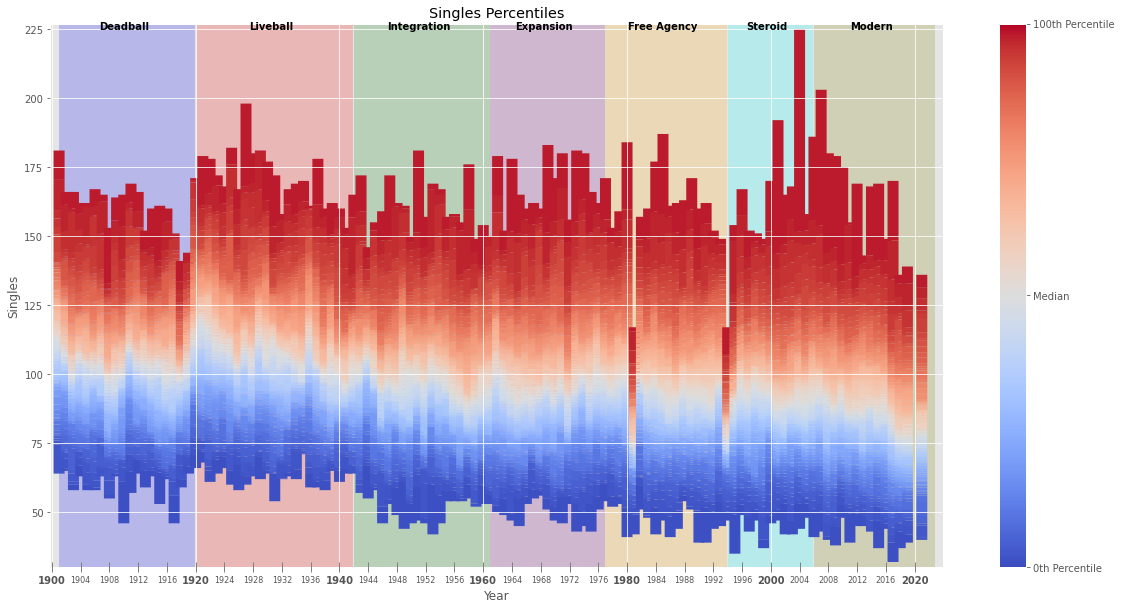

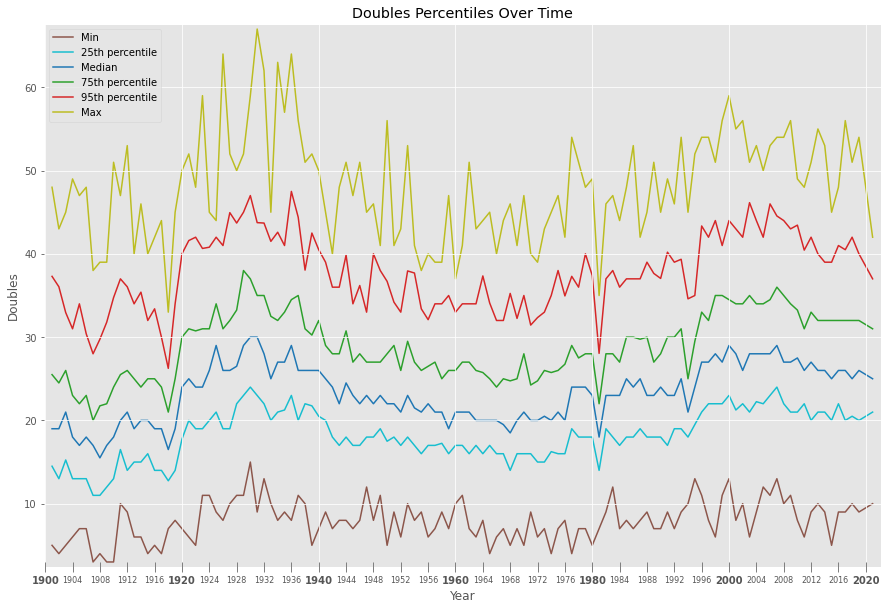

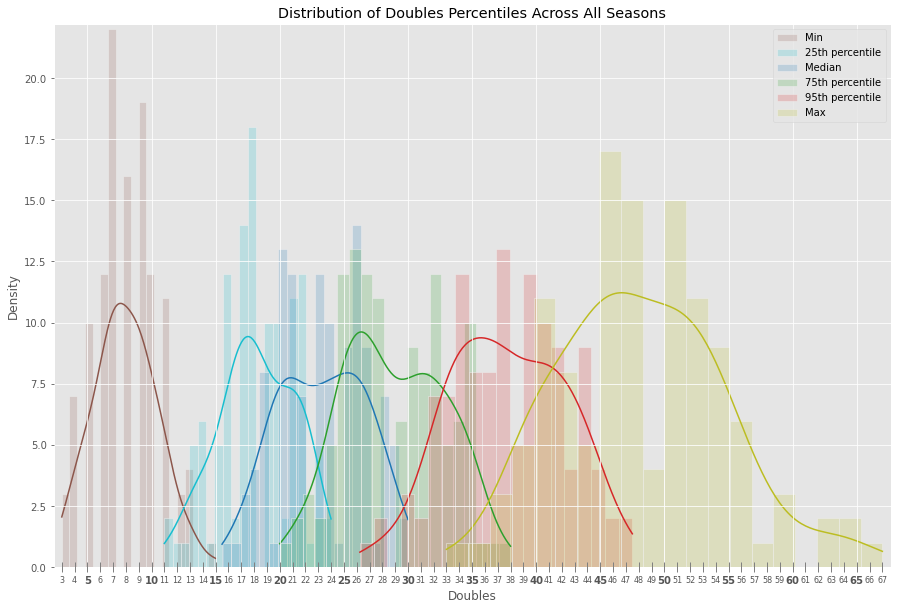

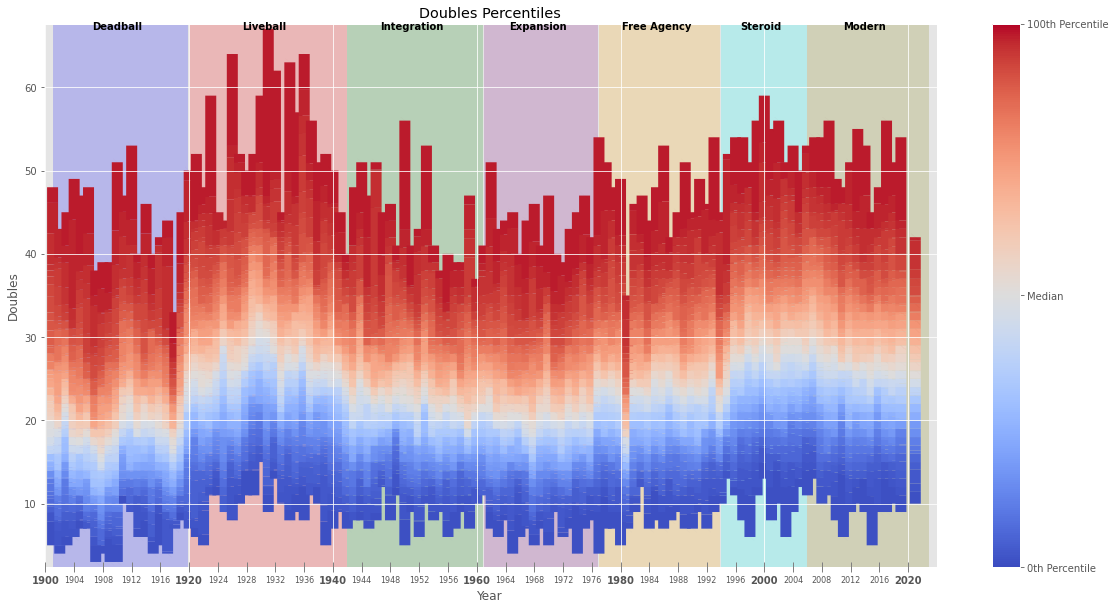

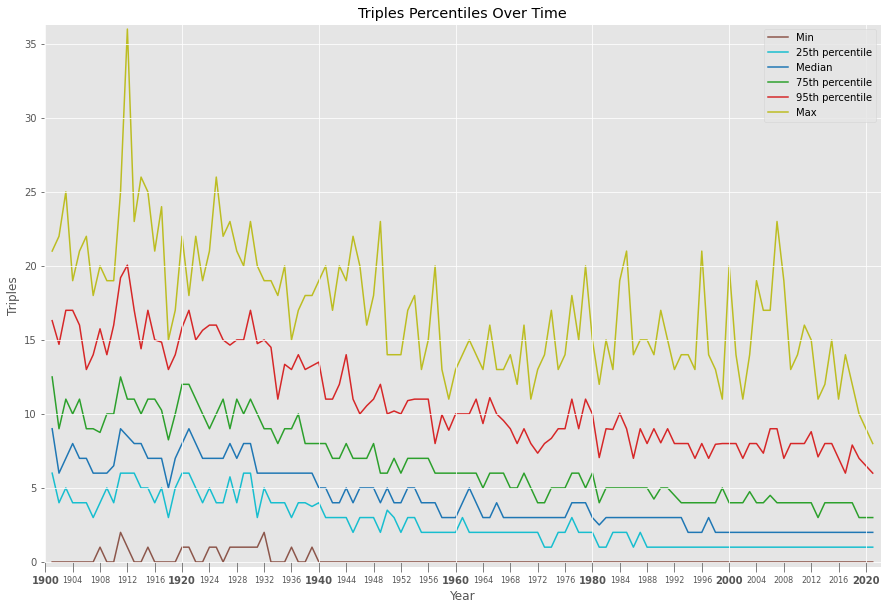

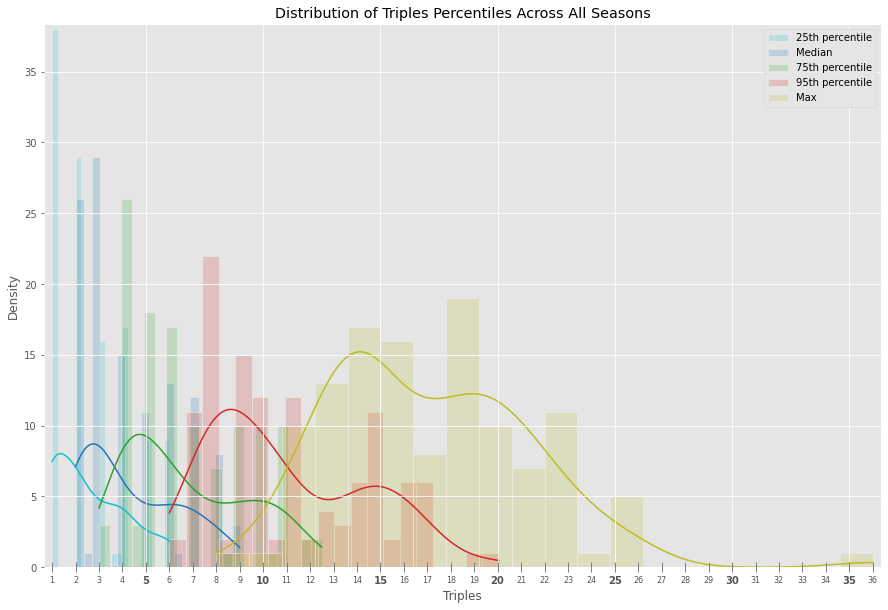

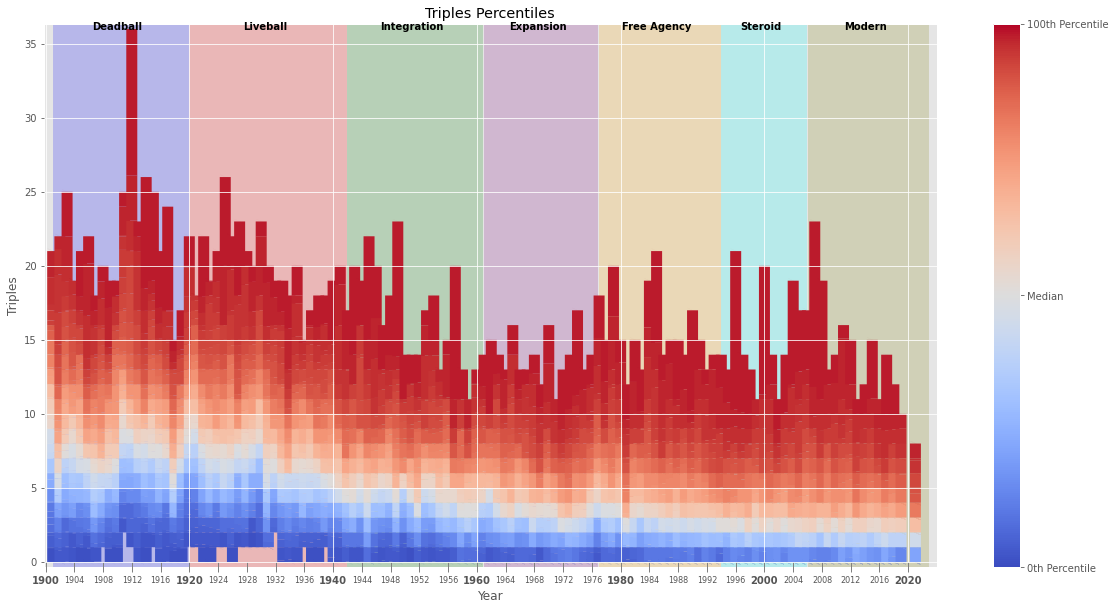

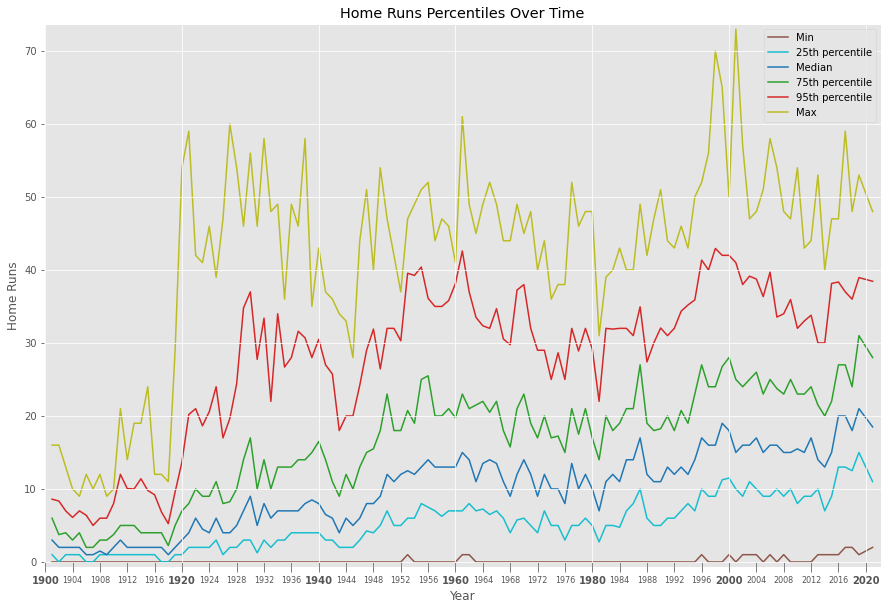

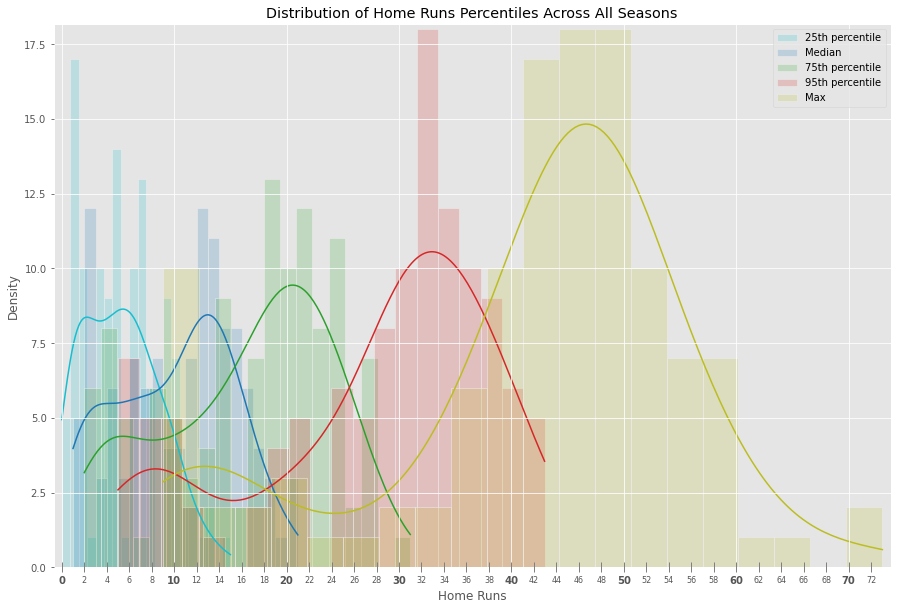

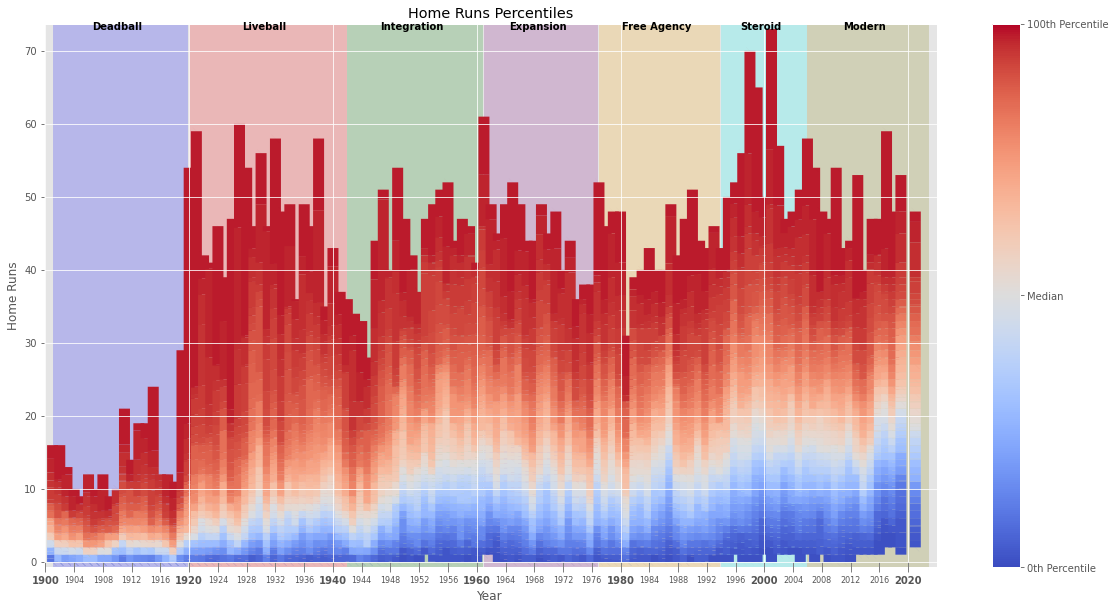

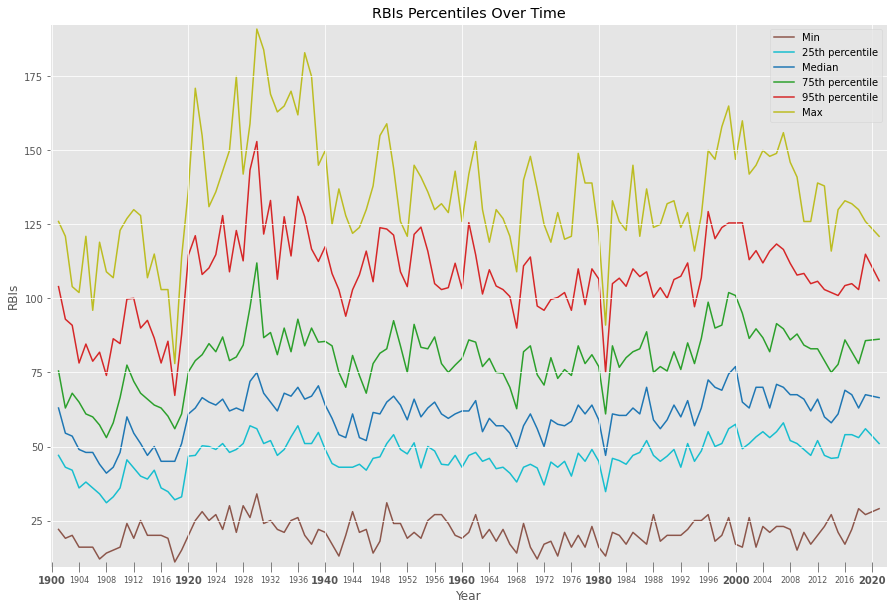

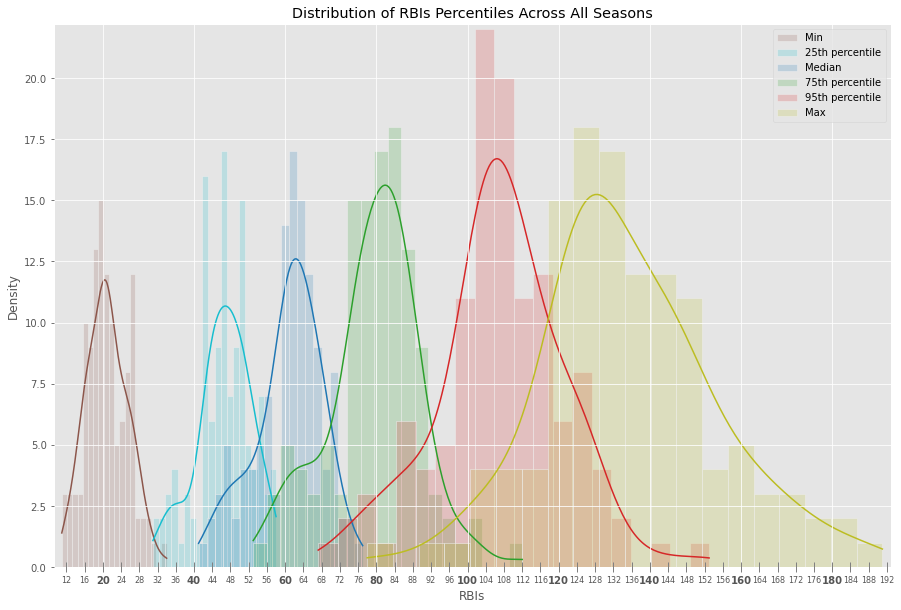

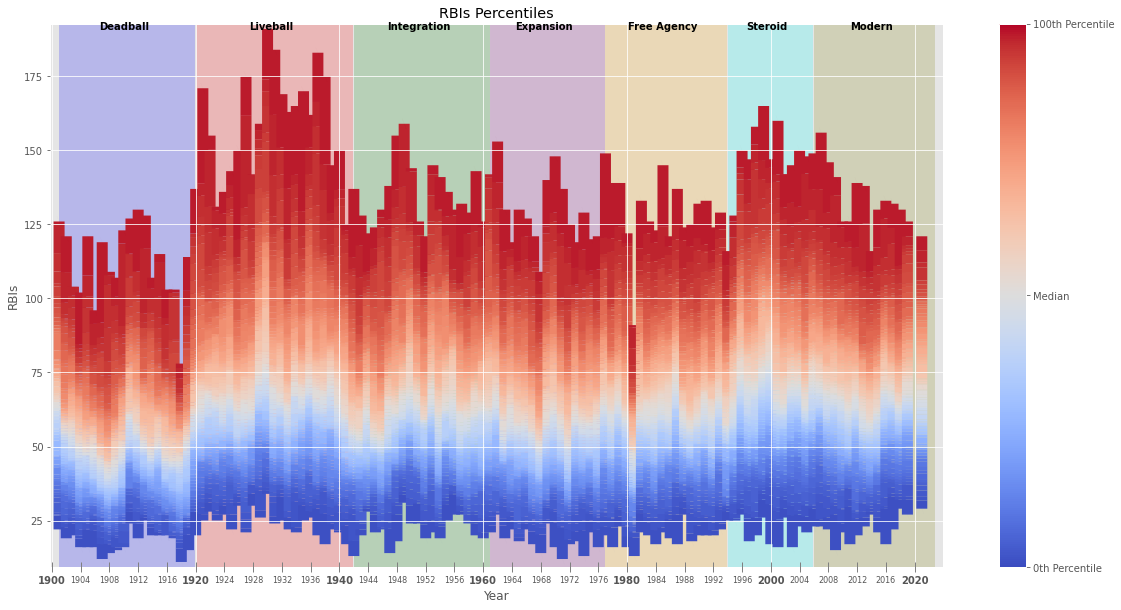

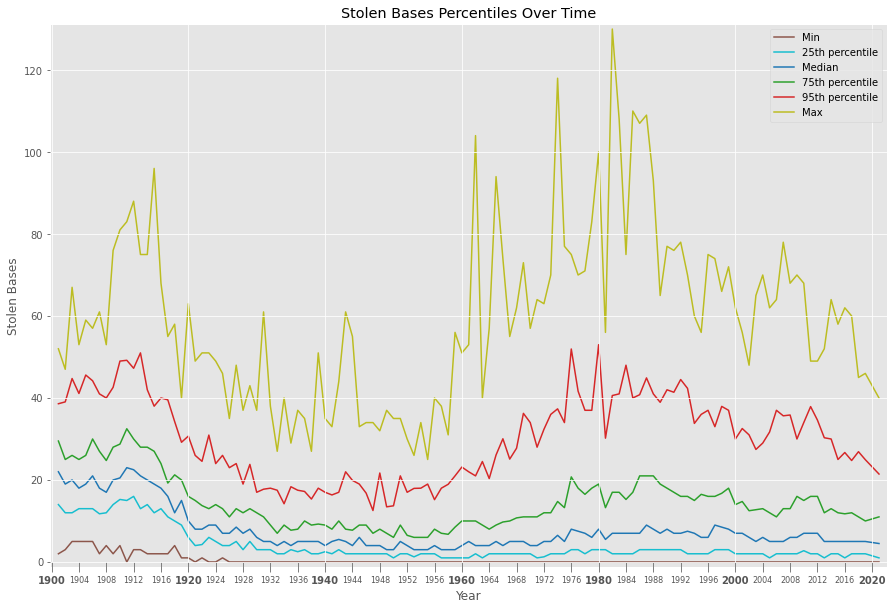

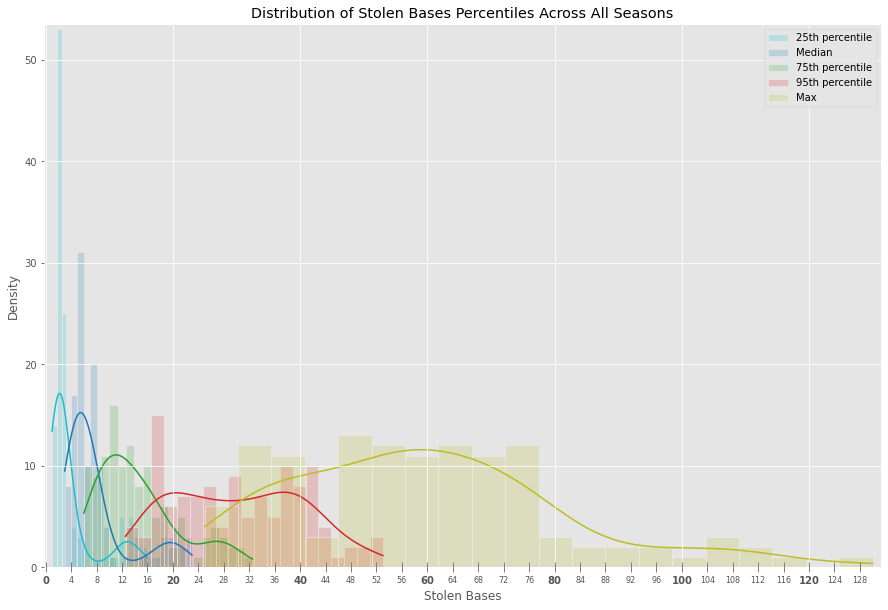

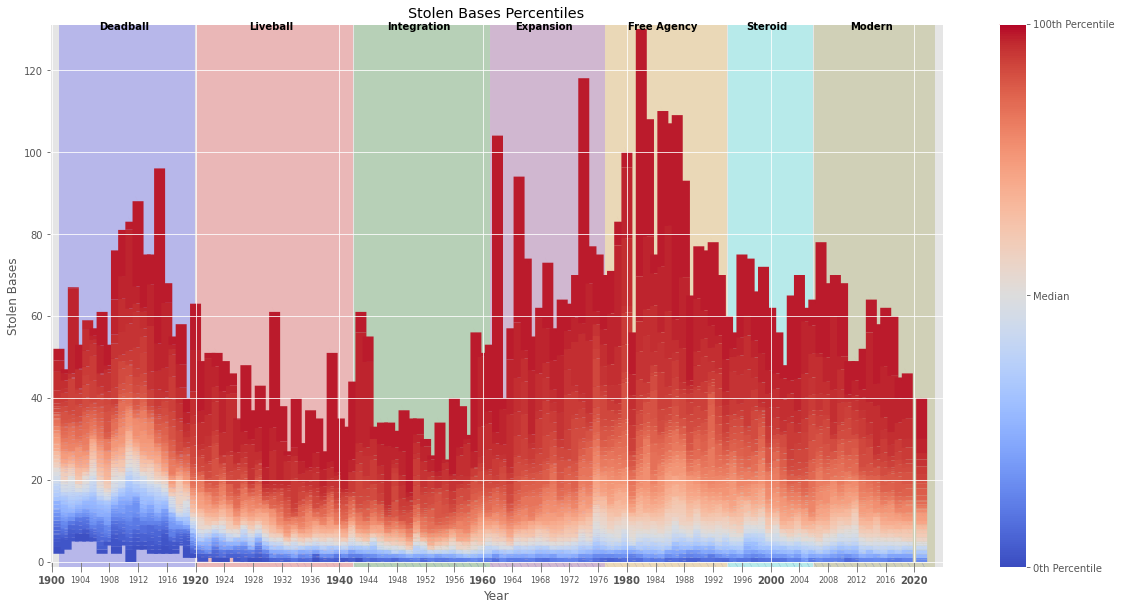

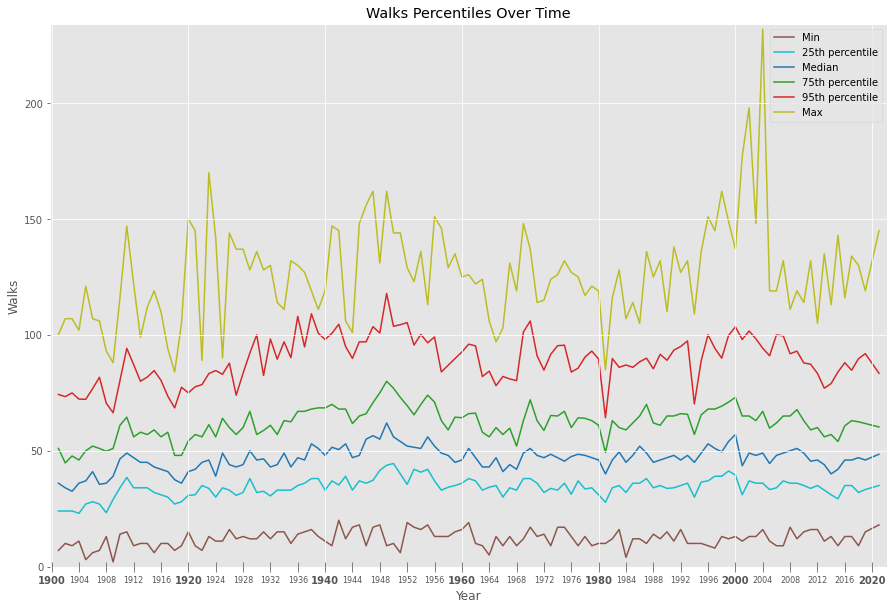

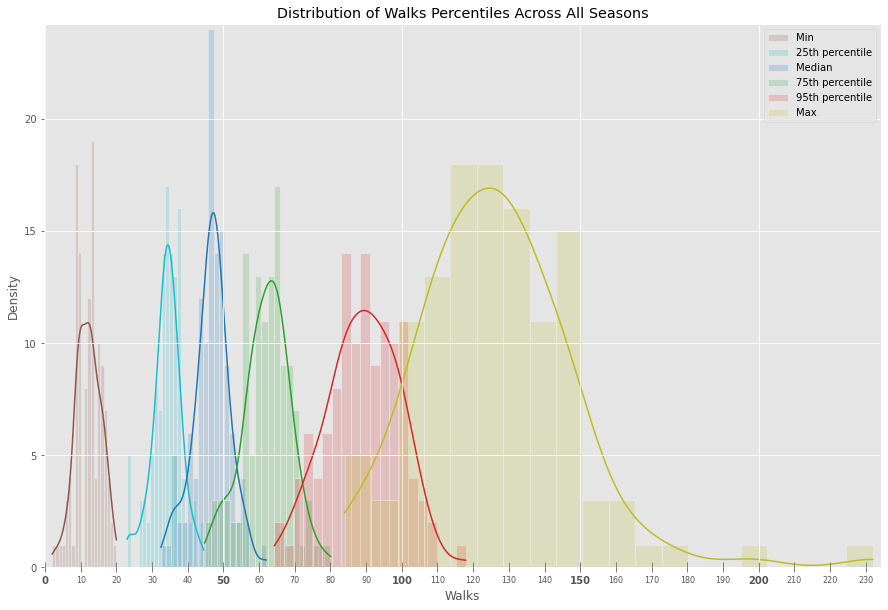

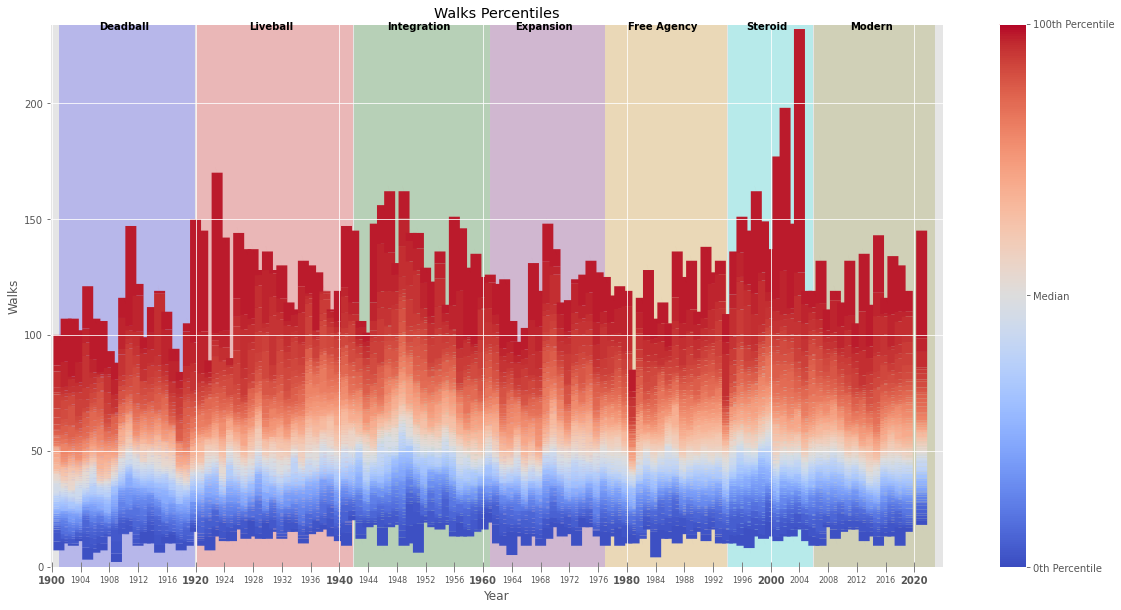

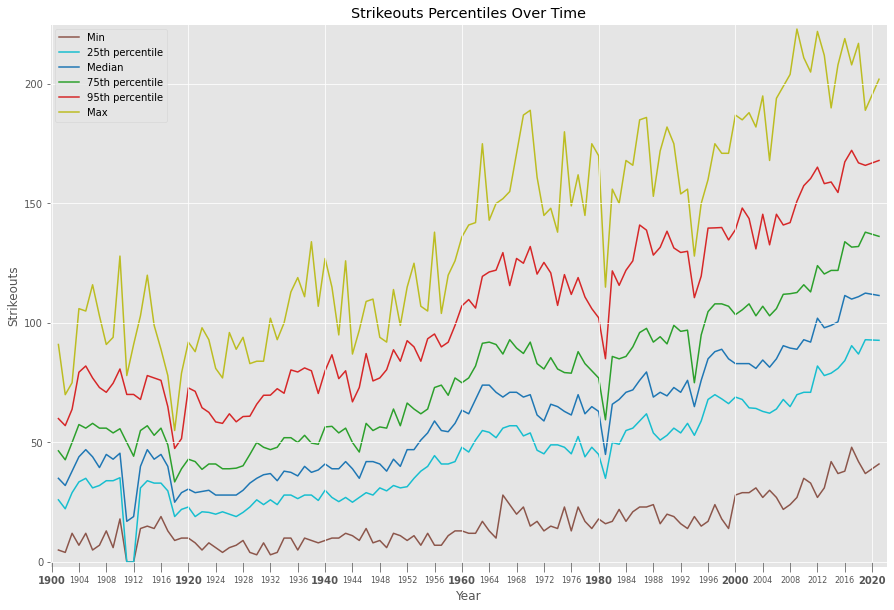

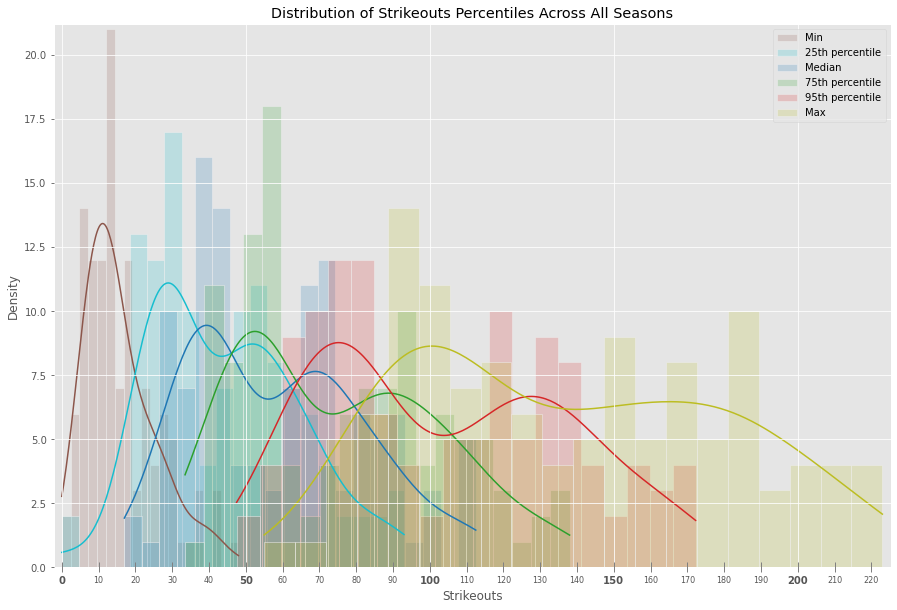

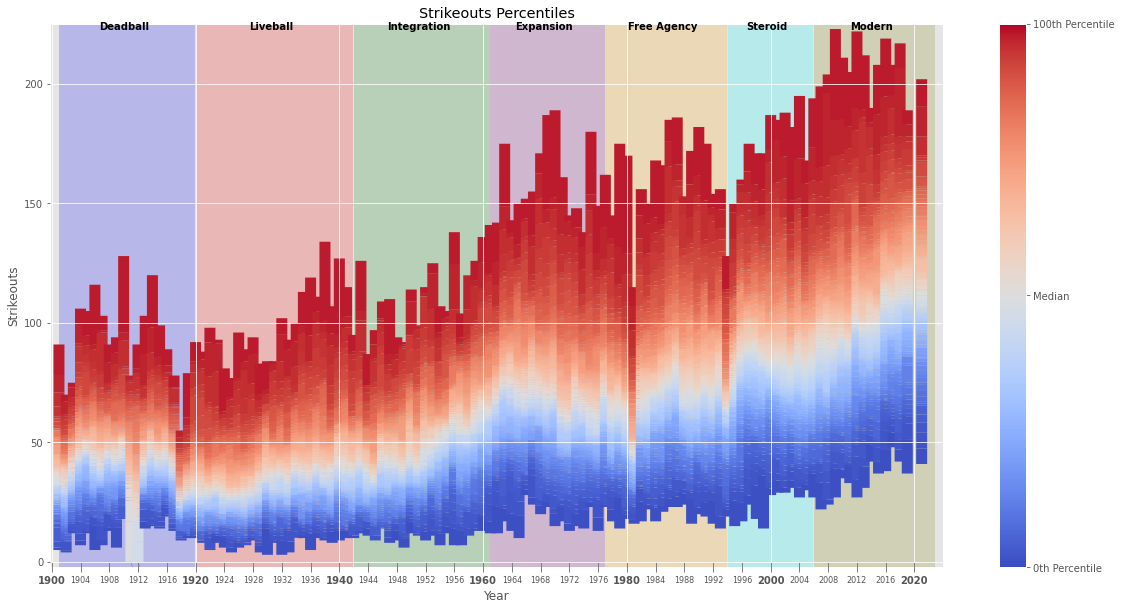

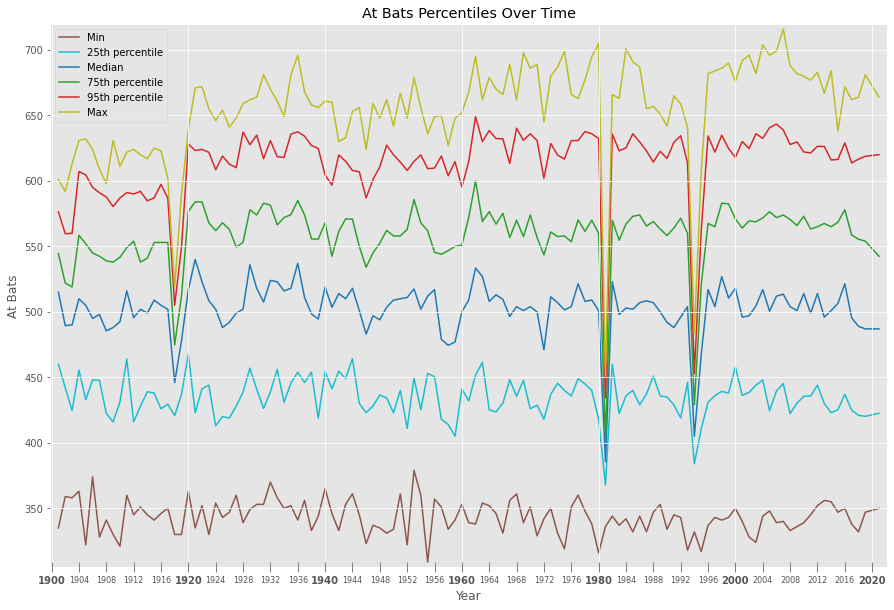

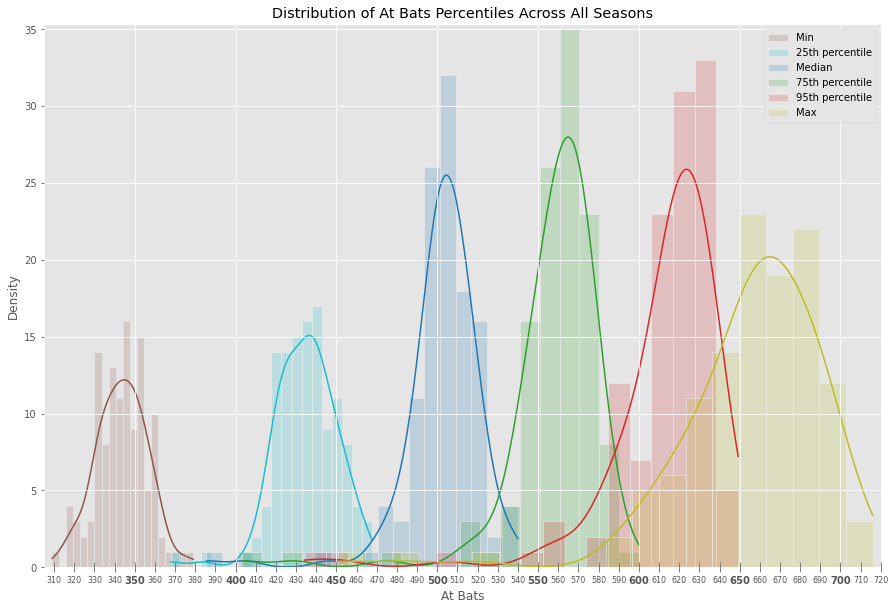

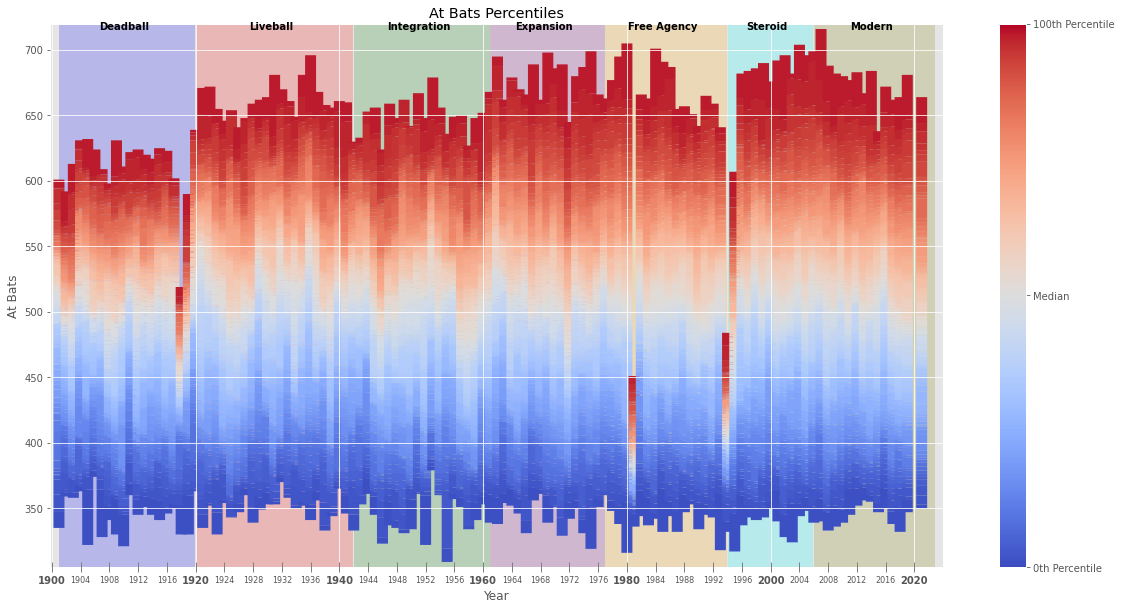

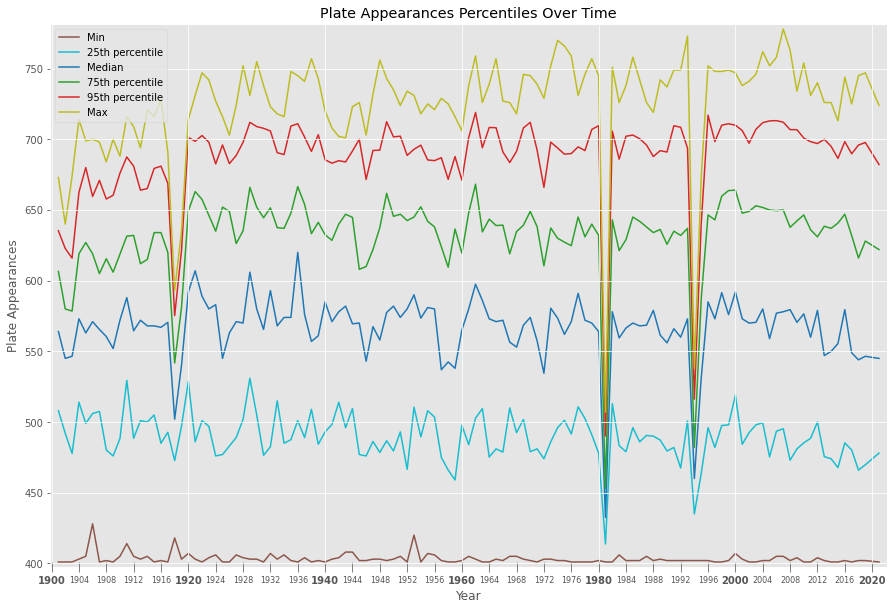

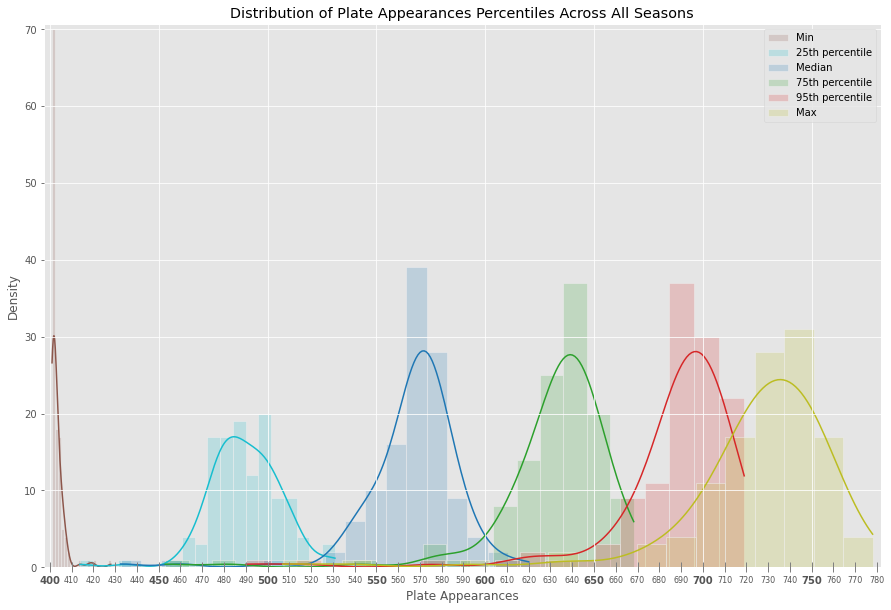

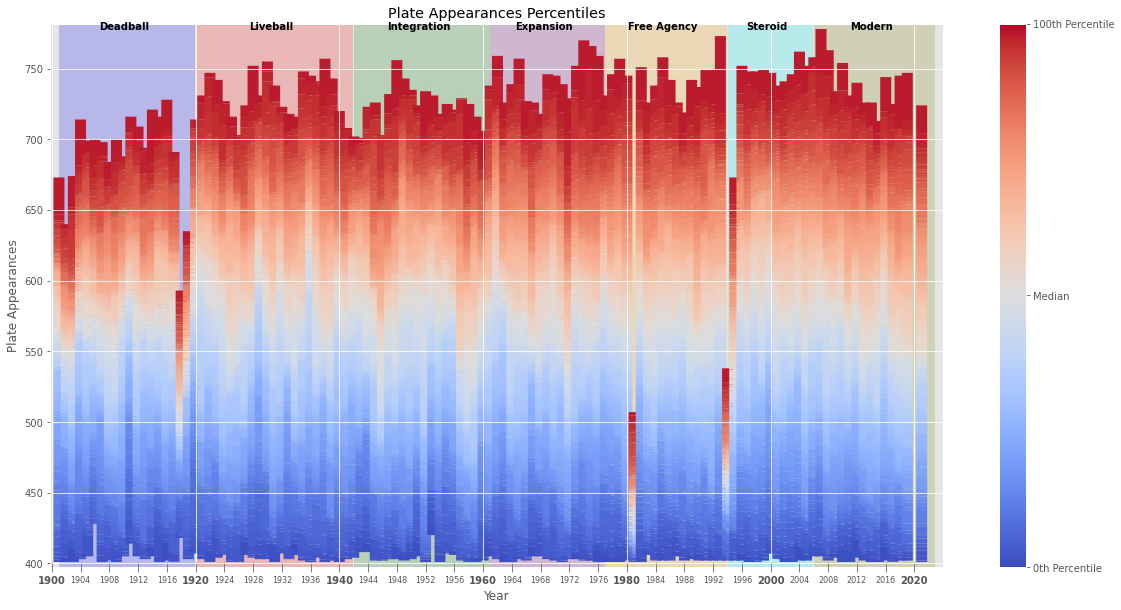

In [39]:
for stat, label in STATS.items():
    plot_line(stat, label, df_stats_by_year)
    plot_hist(stat, label, df_stats_by_year, STAT_2_MAJORTICK[stat])
    plot_gradient(stat, label, df_stats_by_year)

In [309]:
# stat_range = np.array([ round(x, 4) for x in np.arange(0.2, 0.4 + 1e-5, 0.001) ])

# def get_df_dots(stat: str, stat_range: np.ndarray, df_stats_by_year: pd.DataFrame) -> pd.DataFrame:
#     dots = []
#     for val in stat_range:
#         df_val_is_above_threshold = val >= df_stats_by_year[stat][[ x['col'] for x in PERCENTILES ]]
#         for idx, row in df_val_is_above_threshold.iterrows():
#             # row.sum() == # of percentiles that this value is >= than. 
#             # If row.sum() == 0, then this value is < np.nanmin (so ignore it)
#             dots.append({
#                 'val' : val,
#                 'year' : df_stats_by_year['year_id'].loc[idx],
#                 'percentile' : df_val_is_above_threshold.columns[row.sum() - 1] if row.sum() > 0 else 'none',
#             })
#     df_dots = pd.DataFrame(dots)
#     return df_dots

# stat_range = [ round(x, 4) for x in np.arange(0.2, 0.4 + 1e-5, 0.001) ]
# dots = []
# for val in stat_range:
#     df_val_is_above_threshold = val >= df_qual[stat][[ x['col'] for x in PERCENTILES ]]
#     for idx, row in df_val_is_above_threshold.iterrows():
#         # row.sum() == # of percentiles that this value is >= than. 
#         # If row.sum() == 0, then this value is < np.nanmin (so ignore it)
#         dots.append({
#             'val' : val,
#             'year' : df_qual['year_id'].loc[idx],
#             'percentile' : df_val_is_above_threshold.columns[row.sum() - 1] if row.sum() > 0 else 'none',
#         })
# df_dots = pd.DataFrame(dots)

# fig, ax = plt.subplots(figsize=(20,20))
# for percentile in PERCENTILES:
#     col = percentile['col']
#     label = percentile['label']
#     color = percentile['color']
#     df_ = df_dots[df_dots['percentile'] == col]
#     if col == 'nanmax':
#         # Skip "Max" b/c it's confusing in this chart -- 
#         # In this chart, "Max" represents any value that is higher than the max achieved by any player that season
#         continue
#     ax.scatter(df_['year'], df_['val'], color=color, label=label, s=50)
# ax.margins(.01)
# ax.set_title(f"{stat_label} By What Percentile They Are Above")
# ax.set_ylabel(f"{stat_label}")
# ax.set_xlabel(f"Year")
# # Shrink current axis's height by 5% on the bottom
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.05,
#                  box.width, box.height * 0.95])
# # Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=10)

# # ax.scatter(df_stats[df_stats['bbref_id'] == 'troutmi01']['year_id'], df_stats[df_stats['bbref_id'] == 'troutmi01']['avg'], label='Trout', color='k')
# plt.savefig(f"output/dotplot_percentile__{stat}.png")